# Model Training and Evaluation for Energy Poverty Detection
## Training 5 Machine Learning Models with Focus on Recall

**Objective 1**: Build and train at least five different machine learning models
**Objective 3**: Evaluate models with focus on RECALL (detecting vulnerable households)

---

## Models to Train:
1. **Logistic Regression** (Baseline)
2. **Random Forest** (Ensemble)
3. **XGBoost** (Gradient Boosting)
4. **LightGBM** (Gradient Boosting - faster)
5. **LSTM** (Deep Learning - if time permits)

## Evaluation Focus:
- **RECALL** as primary metric (Objective 3)
- Precision, F1-score, AUC-ROC
- Confusion matrices
- Class imbalance handling with SMOTE

## 1. Import Libraries and Setup

In [13]:
# Core libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning - preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer

# Machine Learning - models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

# Machine Learning - evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)

# Handle class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Utilities
import joblib
import time
from datetime import datetime

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"XGBoost version: {xgb.__version__}")
print(f"LightGBM version: {lgb.__version__}")

✓ All libraries imported successfully
Pandas version: 2.3.3
NumPy version: 1.26.4
XGBoost version: 3.1.2
LightGBM version: 4.6.0


## 2. Load Engineered Features Dataset

In [15]:
print("Loading engineered features dataset...")
df = pd.read_csv('energy_features_master.csv')

print("\n" + "="*70)
print("DATASET LOADED SUCCESSFULLY")
print("="*70)
print(f"Total Households: {len(df):,}")
print(f"Total Features: {len(df.columns) - 1:,}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Check for target variable
if 'energy_poor' in df.columns:
    print(f"\nTarget Variable Distribution:")
    print(f"  Energy Poor: {df['energy_poor'].sum():,} ({df['energy_poor'].mean()*100:.2f}%)")
    print(f"  Not Poor: {(df['energy_poor']==0).sum():,} ({(1-df['energy_poor'].mean())*100:.2f}%)")
    print(f"  Class Imbalance Ratio: 1:{(df['energy_poor']==0).sum() / max(df['energy_poor'].sum(), 1):.1f}")
else:
    print("\n⚠️  Warning: Target variable 'energy_poor' not found!")

print("="*70)

df.head()

Loading engineered features dataset...

DATASET LOADED SUCCESSFULLY
Total Households: 5,560
Total Features: 94
Memory Usage: 4.34 MB

Target Variable Distribution:
  Energy Poor: 1,248 (22.45%)
  Not Poor: 4,312 (77.55%)
  Class Imbalance Ratio: 1:3.5


,household_id,mean_consumption,median_consumption,total_consumption,std_consumption,min_consumption,max_consumption,range_consumption,q25_consumption,q75_consumption,q90_consumption,q95_consumption,skewness_consumption,kurtosis_consumption,total_readings,non_zero_readings,zero_consumption_ratio,iqr_consumption,morning_avg_consumption,afternoon_avg_consumption,evening_avg_consumption_x,night_avg_consumption_x,peak_consumption_hour,weekend_avg_consumption,weekday_avg_consumption,weekend_weekday_ratio,day_0_avg_consumption,day_1_avg_consumption,day_2_avg_consumption,day_3_avg_consumption,day_4_avg_consumption,day_5_avg_consumption,day_6_avg_consumption,monthly_consumption_variability,self_disconnect_events,self_disconnect_ratio,max_consecutive_zeros,avg_consecutive_zeros,very_low_consumption_count,very_low_consumption_ratio,evening_avg_consumption_y,evening_zero_ratio,consumption_volatility,daily_consumption_std,daily_consumption_cv,below_avg_consumption_ratio,winter_avg_consumption,winter_min_consumption,winter_zero_ratio,night_avg_consumption_y,night_min_consumption,sharp_drop_count,sharp_drop_ratio,weekend_evening_avg,consumption_regularity,load_factor,base_load,base_load_avg,peak_to_base_ratio,avg_ramp_rate,max_ramp_rate,ramp_rate_std,peak_demand_hours,peak_demand_ratio,off_peak_avg,off_peak_ratio,on_peak_avg,load_diversity,cv_consumption,iqr_normalized,range_normalized,mad_consumption,median_ad_consumption,variance_to_mean,consistency_score,consumption_entropy,distinct_consumption_levels,mode_frequency,winter_avg,winter_std,winter_min,winter_max,winter_zero_count,winter_evening_avg,winter_night_avg,winter_to_annual_ratio,winter_volatility,winter_self_disconnect,quintile_1,quintile_2,quintile_3,quintile_4,quintile_5,energy_poor,vulnerability_score
0,MAC000002,0.2760,0.1785,19.8700,0.2212,0.0760,1.2030,1.1270,0.1182,0.4017,0.5878,0.6695,1.8132,3.7914,72,72,0.0000,0.2835,0.2223,0.2926,0.4454,0.2308,17,0.3812,0.2409,1.5826,0.2402,0.2023,0.2102,0.2476,0.3494,0.4527,0.3357,0.0833,0,0.0000,0,0.0000,8,0.1111,0.4454,0.0000,0.8014,0.2432,0.8078,0.6528,0.3052,0.0760,0.0000,0.2131,0.1010,5,0.0694,0.9445,0.5551,0.2294,0.0760,0.1052,15.8287,0.2280,0.8650,0.2069,8,0.1111,0.2268,0.2853,0.3021,0.8472,0.8014,1.5882,4.0837,0.1696,0.0725,0.1772,0.5551,1.5038,61.0000,0.0417,0.3052,0.2531,0.0760,1.2030,0.0000,0.6095,0.3091,1.1058,0.8293,0.0000,0,0,0,1,0,0,0
1,MAC000003,0.2846,0.1470,29.6030,0.3975,0.0070,2.6670,2.6600,0.0900,0.2740,0.6275,1.1534,3.4845,14.2970,104,104,0.0000,0.1840,0.3810,0.1681,0.2017,0.3972,1,0.2831,0.2854,0.9920,0.2010,0.1919,0.3367,0.4167,0.3378,0.3542,0.2475,0.1527,0,0.0000,0,0.0000,11,0.1058,0.2018,0.0000,1.3963,0.4224,1.3984,0.7692,0.3849,0.0540,0.0000,0.4324,0.0540,8,0.0769,0.2750,0.4173,0.1067,0.0070,0.0665,380.9456,0.2634,2.2460,0.3925,11,0.1058,0.4367,0.4425,0.2230,0.8846,1.3963,1.2517,9.3450,0.2342,0.0705,0.5550,0.4173,0.9316,92.0000,0.0192,0.3849,0.6167,0.0540,2.6670,0.0000,0.1945,1.2338,1.3523,1.6022,0.0000,0,0,0,1,0,0,1
2,MAC000004,0.0332,0.0000,3.1500,0.0667,0.0000,0.2100,0.2100,0.0000,0.0045,0.1702,0.1818,1.6895,1.0369,95,24,0.7474,0.0045,0.0345,0.0364,0.0326,0.0282,6,0.0382,0.0315,1.2130,0.0233,0.0370,0.0127,0.0672,0.0183,0.0408,0.0350,0.0232,53,0.7361,18,4.7333,0,0.0000,0.0326,0.6190,2.0122,0.0765,2.0634,0.7895,0.0531,0.0000,0.6000,0.0161,0.0000,0,0.0000,0.0645,0.3320,0.1579,0.0090,0.0303,23.3307,0.0465,0.2100,0.0733,10,0.1053,0.0403,0.3197,0.0306,0.2421,2.0122,4500.0000,6.3331,0.0506,0.0000,0.1343,0.3320,0.8976,23.0000,0.7474,0.0531,0.0795,0.0000,0.2100,12.0000,0.0445,0.0810,1.6014,1.4976,0.6667,1,0,0,0,0,1,5
3,MAC000005,0.1005,0.0380,9.1460,0.1310,0.0270,0.7350,0.7080,0.0330,0.1050,0.2660,0.3555,2.6369,7.4851,91,91,0.0000,0.0720,0.0853,0.1199,0.1756,0.0353,7,0.1594,0.0860,1.8546,0.0827,0.0688,0.0711,0.0722,0.1203,0.1464,0.1699,0.0623,0,0.0000,0,0.0000,9,0.0989,0.1756,0.0000,1.3035,0.1352,1.2567,0.7473,0.1153,0.0270,0.0000,0.0344,0.0270,1,0.0110,0.2167,0.4341,0.1367,0.0270,0.0310,27.2212,0.1202,0.7030,0.1589,1

## 3. Prepare Data for Modeling

In [18]:
print("\n🔧 PREPARING DATA FOR MODELING\n")
print("="*70)

# Separate features and target
exclude_cols = ['household_id', 'energy_poor', 'vulnerability_score']
feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols].copy()
y = df['energy_poor'].copy()

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"\nNumber of features: {len(feature_cols)}")

# Handle any remaining missing values
if X.isnull().sum().sum() > 0:
    print(f"\n⚠️  Found {X.isnull().sum().sum()} missing values - filling with 0")
    X = X.fillna(0)

# Handle infinite values
X = X.replace([np.inf, -np.inf], 0)

print("\n✓ Data preparation complete")
print("="*70)


🔧 PREPARING DATA FOR MODELING

Features (X): (5560, 92)
Target (y): (5560,)

Number of features: 92

✓ Data preparation complete


## 4. Train-Test Split with Stratification

In [21]:
print("\n📊 SPLITTING DATA INTO TRAIN AND TEST SETS\n")
print("="*70)

# Split with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training Set:")
print(f"  Total: {len(X_train):,} samples")
print(f"  Energy Poor: {y_train.sum():,} ({y_train.mean()*100:.2f}%)")
print(f"  Not Poor: {(y_train==0).sum():,} ({(1-y_train.mean())*100:.2f}%)")

print(f"\nTest Set:")
print(f"  Total: {len(X_test):,} samples")
print(f"  Energy Poor: {y_test.sum():,} ({y_test.mean()*100:.2f}%)")
print(f"  Not Poor: {(y_test==0).sum():,} ({(1-y_test.mean())*100:.2f}%)")

print("\n✓ Train-test split complete")
print("="*70)


📊 SPLITTING DATA INTO TRAIN AND TEST SETS

Training Set:
  Total: 4,448 samples
  Energy Poor: 998 (22.44%)
  Not Poor: 3,450 (77.56%)

Test Set:
  Total: 1,112 samples
  Energy Poor: 250 (22.48%)
  Not Poor: 862 (77.52%)

✓ Train-test split complete


## 5. Feature Scaling

In [24]:
print("\n🔧 SCALING FEATURES\n")
print("="*70)

# Use RobustScaler to handle outliers better than StandardScaler
scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✓ Feature scaling complete using RobustScaler")
print("="*70)


🔧 SCALING FEATURES

✓ Feature scaling complete using RobustScaler


## 6. Handle Class Imbalance with SMOTE

In [27]:
print("\n⚖️ HANDLING CLASS IMBALANCE WITH SMOTE\n")
print("="*70)

# Apply SMOTE to create synthetic samples of minority class
print("Before SMOTE:")
print(f"  Energy Poor: {y_train.sum():,}")
print(f"  Not Poor: {(y_train==0).sum():,}")
print(f"  Ratio: 1:{(y_train==0).sum() / max(y_train.sum(), 1):.1f}")

# Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("\nAfter SMOTE:")
print(f"  Energy Poor: {y_train_balanced.sum():,}")
print(f"  Not Poor: {(y_train_balanced==0).sum():,}")
print(f"  Ratio: 1:{(y_train_balanced==0).sum() / max(y_train_balanced.sum(), 1):.1f}")

print(f"\n✓ Class balance improved")
print(f"  Training set size increased from {len(y_train):,} to {len(y_train_balanced):,}")
print("="*70)


⚖️ HANDLING CLASS IMBALANCE WITH SMOTE

Before SMOTE:
  Energy Poor: 998
  Not Poor: 3,450
  Ratio: 1:3.5

After SMOTE:
  Energy Poor: 3,450
  Not Poor: 3,450
  Ratio: 1:1.0

✓ Class balance improved
  Training set size increased from 4,448 to 6,900


## 7. Define Evaluation Functions

In [29]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Comprehensive model evaluation with focus on RECALL.
    """
    print(f"\n{'='*70}")
    print(f"EVALUATING: {model_name}")
    print(f"{'='*70}")
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_pred
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)  # PRIMARY METRIC
    f1 = f1_score(y_test, y_pred)
    
    # ROC-AUC
    try:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    except:
        roc_auc = 0.0
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    
    # Print results
    print(f"\n📊 PERFORMANCE METRICS:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  RECALL:    {recall:.4f} ⭐ PRIMARY METRIC")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")
    
    print(f"\n📈 CONFUSION MATRIX:")
    print(f"  True Negatives:  {tn:,}")
    print(f"  False Positives: {fp:,}")
    print(f"  False Negatives: {fn:,} ⚠️ (Missing vulnerable households)")
    print(f"  True Positives:  {tp:,}")
    
    # Calculate additional metrics
    if tp + fn > 0:
        detection_rate = tp / (tp + fn)
        print(f"\n  Detection Rate: {detection_rate:.2%} (of actual energy-poor households)")
    
    if fp + tn > 0:
        false_alarm_rate = fp / (fp + tn)
        print(f"  False Alarm Rate: {false_alarm_rate:.2%}")
    
    print(f"\n{'='*70}")
    
    # Return metrics dictionary
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'true_negatives': tn,
        'false_positives': fp,
        'false_negatives': fn,
        'true_positives': tp,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

def plot_confusion_matrix(cm, model_name):
    """
    Plot confusion matrix heatmap.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Not Poor', 'Energy Poor'],
                yticklabels=['Not Poor', 'Energy Poor'],
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontweight='bold')
    plt.xlabel('Predicted', fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_test, y_pred_proba, model_name):
    """
    Plot ROC curve.
    """
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontweight='bold')
    plt.ylabel('True Positive Rate (Recall)', fontweight='bold')
    plt.title(f'ROC Curve - {model_name}', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

print("✓ Evaluation functions defined")

✓ Evaluation functions defined


## 8. Model 1: Logistic Regression (Baseline)


MODEL 1: LOGISTIC REGRESSION (BASELINE)

Training Logistic Regression...
✓ Training completed in 0.43 seconds

EVALUATING: Logistic Regression

📊 PERFORMANCE METRICS:
  Accuracy:  0.9766
  Precision: 0.9375
  RECALL:    0.9600 ⭐ PRIMARY METRIC
  F1-Score:  0.9486
  ROC-AUC:   0.9940

📈 CONFUSION MATRIX:
  True Negatives:  846
  False Positives: 16
  False Negatives: 10 ⚠️ (Missing vulnerable households)
  True Positives:  240

  Detection Rate: 96.00% (of actual energy-poor households)
  False Alarm Rate: 1.86%



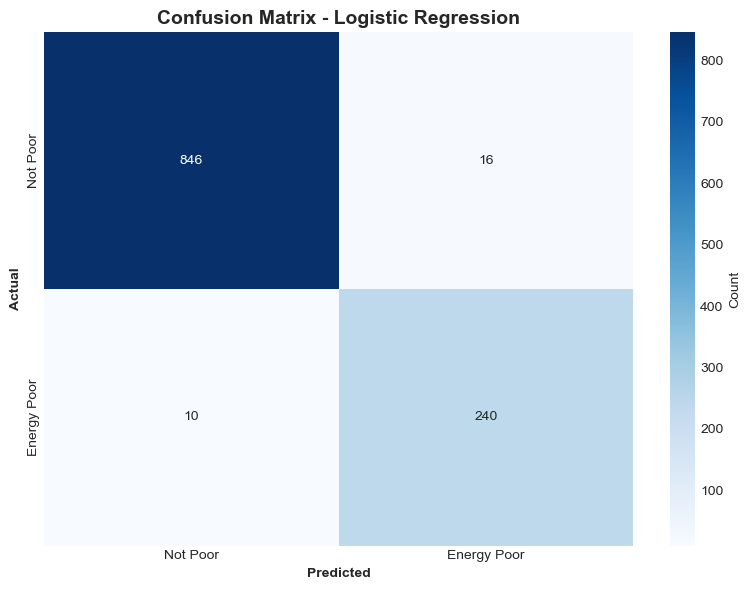

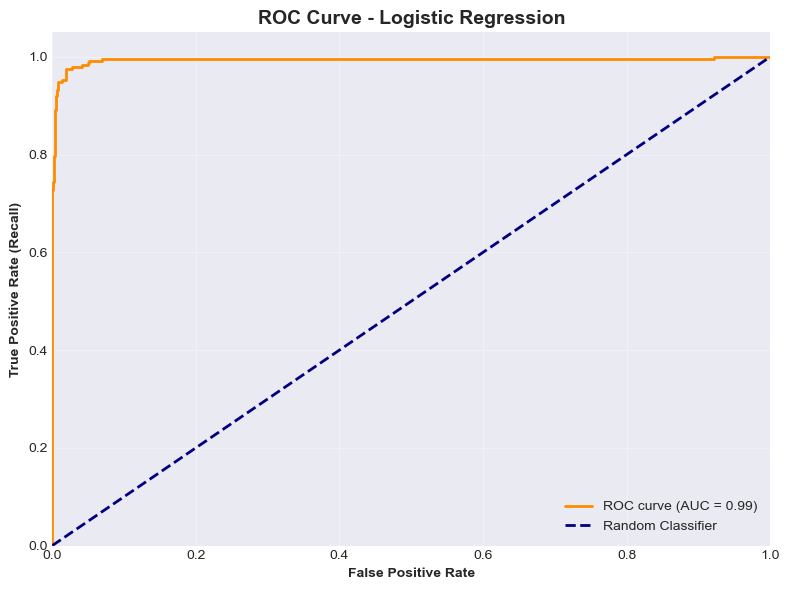


✓ Model saved: model_logistic_regression.pkl


In [31]:
print("\n" + "="*70)
print("MODEL 1: LOGISTIC REGRESSION (BASELINE)")
print("="*70)

# Train model
print("\nTraining Logistic Regression...")
start_time = time.time()

lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced',  # Handle any remaining imbalance
    solver='lbfgs'
)

lr_model.fit(X_train_balanced, y_train_balanced)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds")

# Evaluate
lr_results = evaluate_model(lr_model, X_test_scaled, y_test, "Logistic Regression")

# Visualizations
plot_confusion_matrix(
    confusion_matrix(y_test, lr_results['y_pred']), 
    "Logistic Regression"
)

plot_roc_curve(y_test, lr_results['y_pred_proba'], "Logistic Regression")

# Save model
joblib.dump(lr_model, 'model_logistic_regression.pkl')
print("\n✓ Model saved: model_logistic_regression.pkl")

## 9. Model 2: Random Forest


MODEL 2: RANDOM FOREST

Training Random Forest...
✓ Training completed in 0.48 seconds

EVALUATING: Random Forest

📊 PERFORMANCE METRICS:
  Accuracy:  0.9910
  Precision: 0.9688
  RECALL:    0.9920 ⭐ PRIMARY METRIC
  F1-Score:  0.9802
  ROC-AUC:   0.9998

📈 CONFUSION MATRIX:
  True Negatives:  854
  False Positives: 8
  False Negatives: 2 ⚠️ (Missing vulnerable households)
  True Positives:  248

  Detection Rate: 99.20% (of actual energy-poor households)
  False Alarm Rate: 0.93%



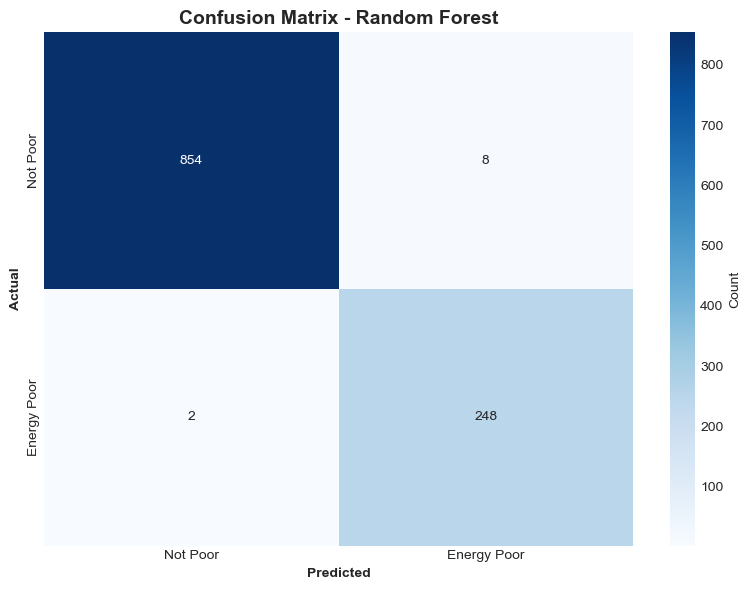

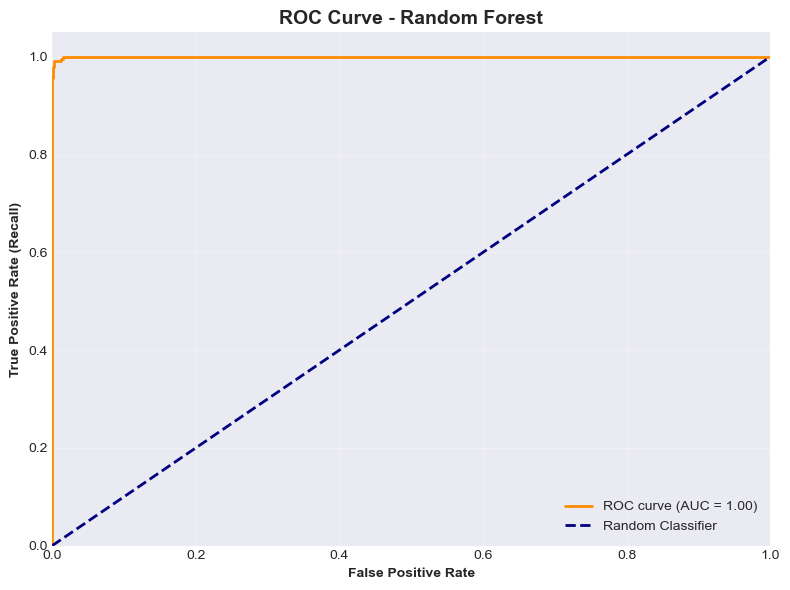

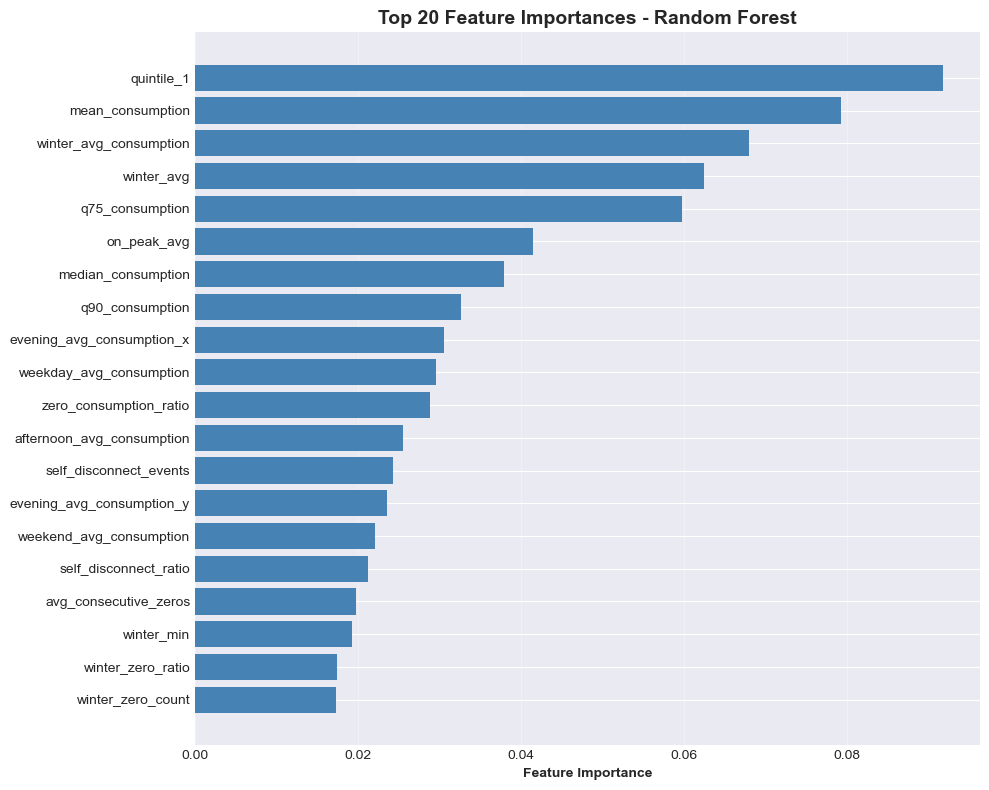


✓ Model saved: model_random_forest.pkl


In [36]:
print("\n" + "="*70)
print("MODEL 2: RANDOM FOREST")
print("="*70)

# Train model
print("\nTraining Random Forest...")
start_time = time.time()

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1  # Use all CPU cores
)

rf_model.fit(X_train_balanced, y_train_balanced)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds")

# Evaluate
rf_results = evaluate_model(rf_model, X_test_scaled, y_test, "Random Forest")

# Visualizations
plot_confusion_matrix(
    confusion_matrix(y_test, rf_results['y_pred']), 
    "Random Forest"
)

plot_roc_curve(y_test, rf_results['y_pred_proba'], "Random Forest")

# Feature importance (top 20)
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(range(len(feature_importance)), feature_importance['importance'].values, color='steelblue')
plt.yticks(range(len(feature_importance)), feature_importance['feature'].values)
plt.xlabel('Feature Importance', fontweight='bold')
plt.title('Top 20 Feature Importances - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Save model
joblib.dump(rf_model, 'model_random_forest.pkl')
print("\n✓ Model saved: model_random_forest.pkl")

## 10. Model 3: XGBoost


MODEL 3: XGBOOST

Training XGBoost...
✓ Training completed in 0.61 seconds

EVALUATING: XGBoost

📊 PERFORMANCE METRICS:
  Accuracy:  0.9973
  Precision: 0.9920
  RECALL:    0.9960 ⭐ PRIMARY METRIC
  F1-Score:  0.9940
  ROC-AUC:   0.9999

📈 CONFUSION MATRIX:
  True Negatives:  860
  False Positives: 2
  False Negatives: 1 ⚠️ (Missing vulnerable households)
  True Positives:  249

  Detection Rate: 99.60% (of actual energy-poor households)
  False Alarm Rate: 0.23%



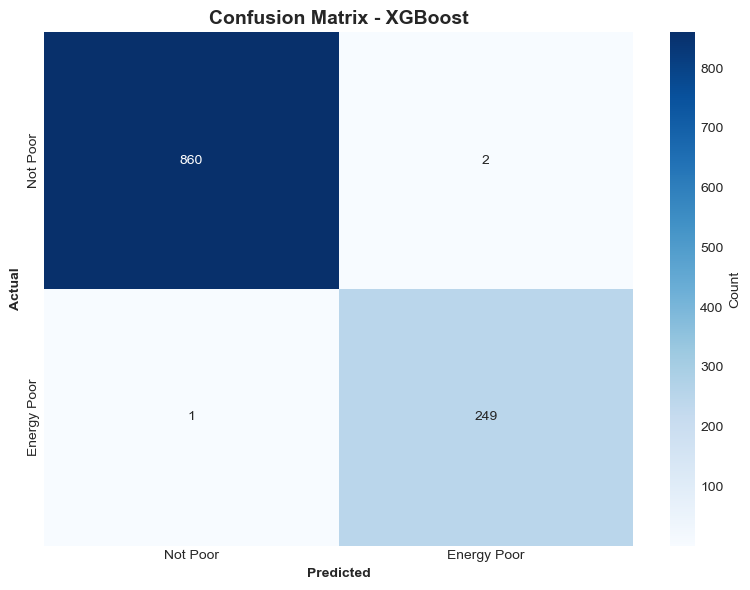

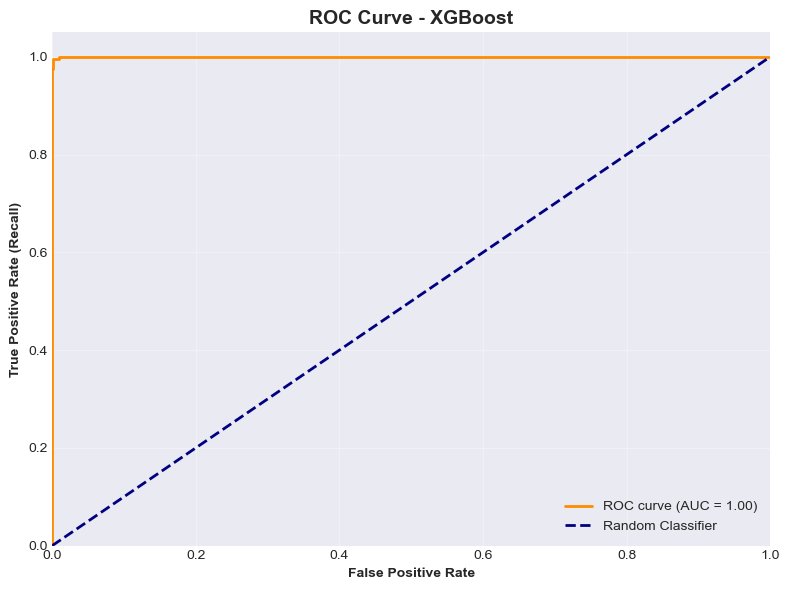

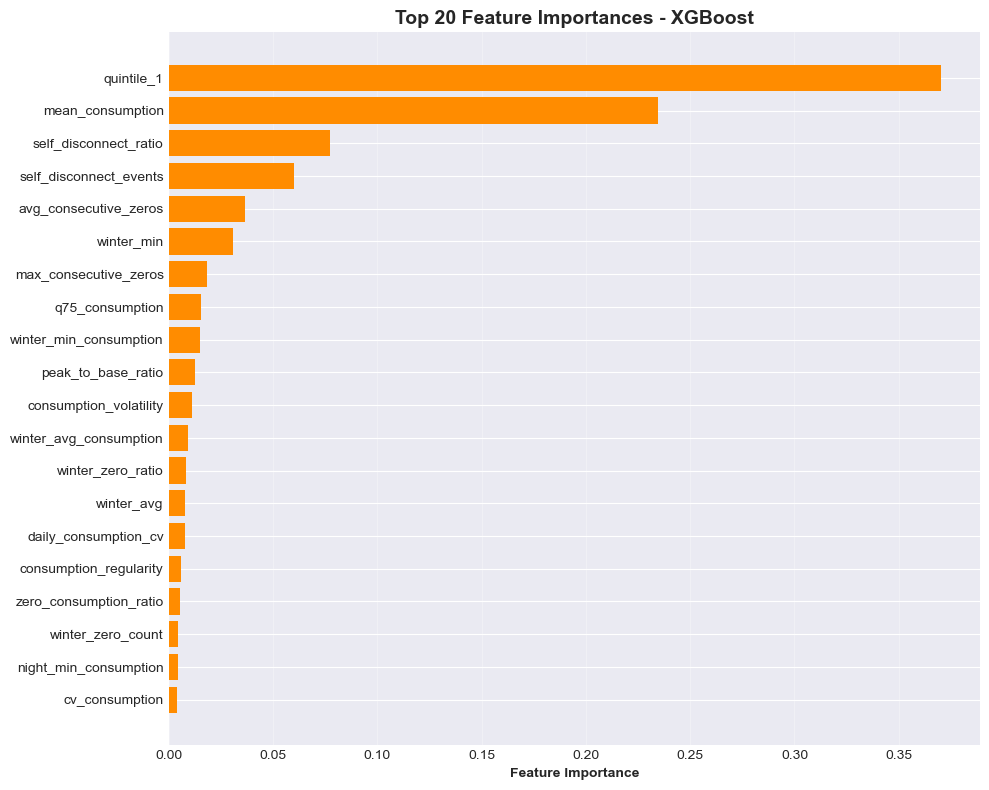


✓ Model saved: model_xgboost.pkl


In [38]:
print("\n" + "="*70)
print("MODEL 3: XGBOOST")
print("="*70)

# Train model
print("\nTraining XGBoost...")
start_time = time.time()

# Calculate scale_pos_weight for imbalance
scale_pos_weight = (y_train_balanced == 0).sum() / (y_train_balanced == 1).sum()

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss',
    n_jobs=-1
)

xgb_model.fit(X_train_balanced, y_train_balanced)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds")

# Evaluate
xgb_results = evaluate_model(xgb_model, X_test_scaled, y_test, "XGBoost")

# Visualizations
plot_confusion_matrix(
    confusion_matrix(y_test, xgb_results['y_pred']), 
    "XGBoost"
)

plot_roc_curve(y_test, xgb_results['y_pred_proba'], "XGBoost")

# Feature importance (top 20)
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(range(len(feature_importance)), feature_importance['importance'].values, color='darkorange')
plt.yticks(range(len(feature_importance)), feature_importance['feature'].values)
plt.xlabel('Feature Importance', fontweight='bold')
plt.title('Top 20 Feature Importances - XGBoost', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Save model
joblib.dump(xgb_model, 'model_xgboost.pkl')
print("\n✓ Model saved: model_xgboost.pkl")

## 11. Model 4: LightGBM


MODEL 4: LIGHTGBM

Training LightGBM...
✓ Training completed in 0.44 seconds

EVALUATING: LightGBM

📊 PERFORMANCE METRICS:
  Accuracy:  0.9982
  Precision: 0.9960
  RECALL:    0.9960 ⭐ PRIMARY METRIC
  F1-Score:  0.9960
  ROC-AUC:   0.9999

📈 CONFUSION MATRIX:
  True Negatives:  861
  False Positives: 1
  False Negatives: 1 ⚠️ (Missing vulnerable households)
  True Positives:  249

  Detection Rate: 99.60% (of actual energy-poor households)
  False Alarm Rate: 0.12%



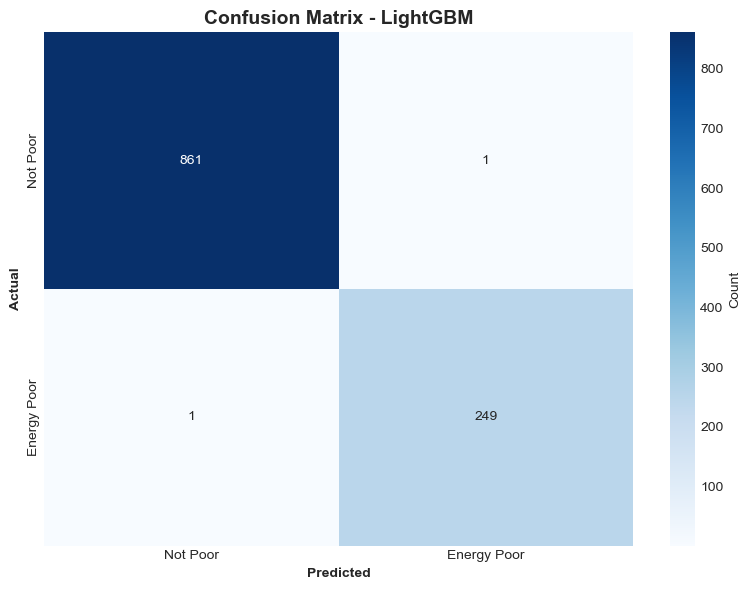

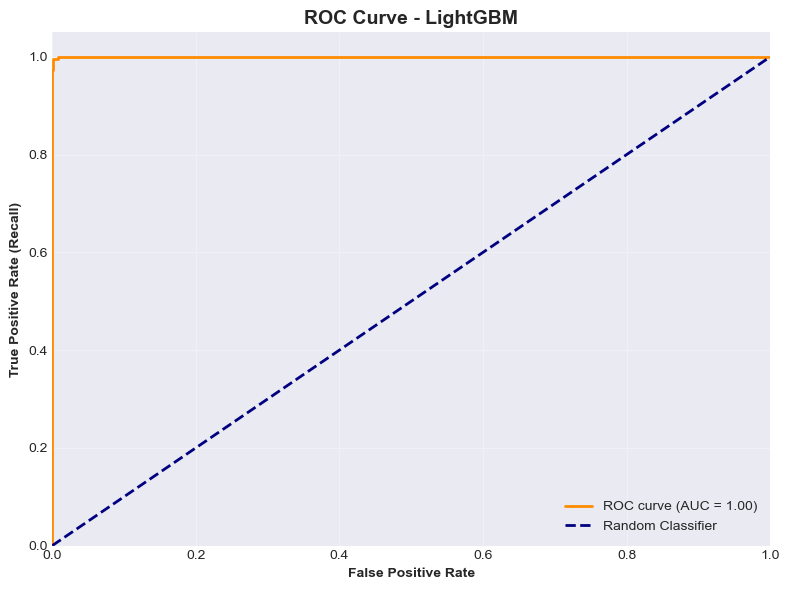

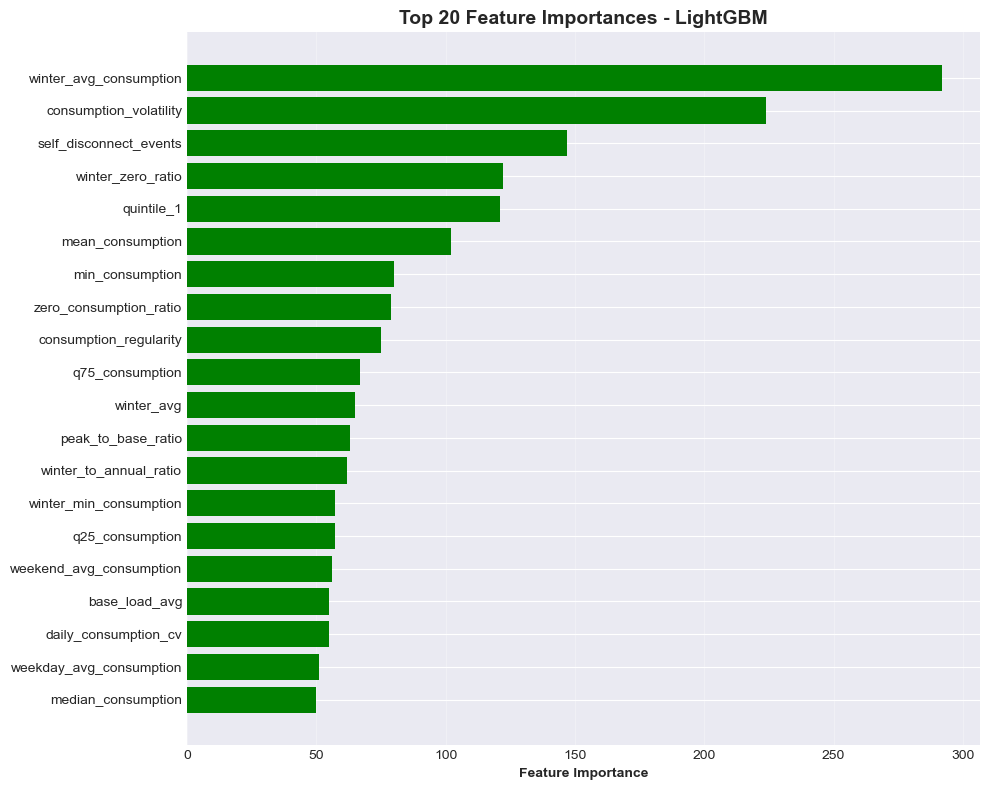


✓ Model saved: model_lightgbm.pkl


In [41]:
print("\n" + "="*70)
print("MODEL 4: LIGHTGBM")
print("="*70)

# Train model
print("\nTraining LightGBM...")
start_time = time.time()

lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=-1  # Suppress warnings
)

lgb_model.fit(X_train_balanced, y_train_balanced)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds")

# Evaluate
lgb_results = evaluate_model(lgb_model, X_test_scaled, y_test, "LightGBM")

# Visualizations
plot_confusion_matrix(
    confusion_matrix(y_test, lgb_results['y_pred']), 
    "LightGBM"
)

plot_roc_curve(y_test, lgb_results['y_pred_proba'], "LightGBM")

# Feature importance (top 20)
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(range(len(feature_importance)), feature_importance['importance'].values, color='green')
plt.yticks(range(len(feature_importance)), feature_importance['feature'].values)
plt.xlabel('Feature Importance', fontweight='bold')
plt.title('Top 20 Feature Importances - LightGBM', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Save model
joblib.dump(lgb_model, 'model_lightgbm.pkl')
print("\n✓ Model saved: model_lightgbm.pkl")

## 12. Model Comparison Summary

In [44]:
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)

# Compile all results
all_results = pd.DataFrame([
    lr_results,
    rf_results,
    xgb_results,
    lgb_results
])

# Select key metrics
comparison_df = all_results[[
    'model_name', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc',
    'true_positives', 'false_negatives', 'false_positives', 'true_negatives'
]].copy()

print("\n📊 PERFORMANCE METRICS COMPARISON:\n")
print(comparison_df.to_string(index=False))

# Find best model by RECALL (primary metric)
best_model_idx = comparison_df['recall'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'model_name']
best_recall = comparison_df.loc[best_model_idx, 'recall']

print(f"\n⭐ BEST MODEL BY RECALL: {best_model_name}")
print(f"   Recall Score: {best_recall:.4f}")
print(f"   This model detected {best_recall*100:.1f}% of energy-poor households")

# Save comparison
comparison_df.to_csv('model_comparison_results.csv', index=False)
print("\n✓ Results saved: model_comparison_results.csv")


MODEL COMPARISON SUMMARY

📊 PERFORMANCE METRICS COMPARISON:

         model_name  accuracy  precision  recall  f1_score  roc_auc  true_positives  false_negatives  false_positives  true_negatives
Logistic Regression    0.9766     0.9375  0.9600    0.9486   0.9940             240               10               16             846
      Random Forest    0.9910     0.9688  0.9920    0.9802   0.9998             248                2                8             854
            XGBoost    0.9973     0.9920  0.9960    0.9940   0.9999             249                1                2             860
           LightGBM    0.9982     0.9960  0.9960    0.9960   0.9999             249                1                1             861

⭐ BEST MODEL BY RECALL: XGBoost
   Recall Score: 0.9960
   This model detected 99.6% of energy-poor households

✓ Results saved: model_comparison_results.csv


## 13. Visual Model Comparison

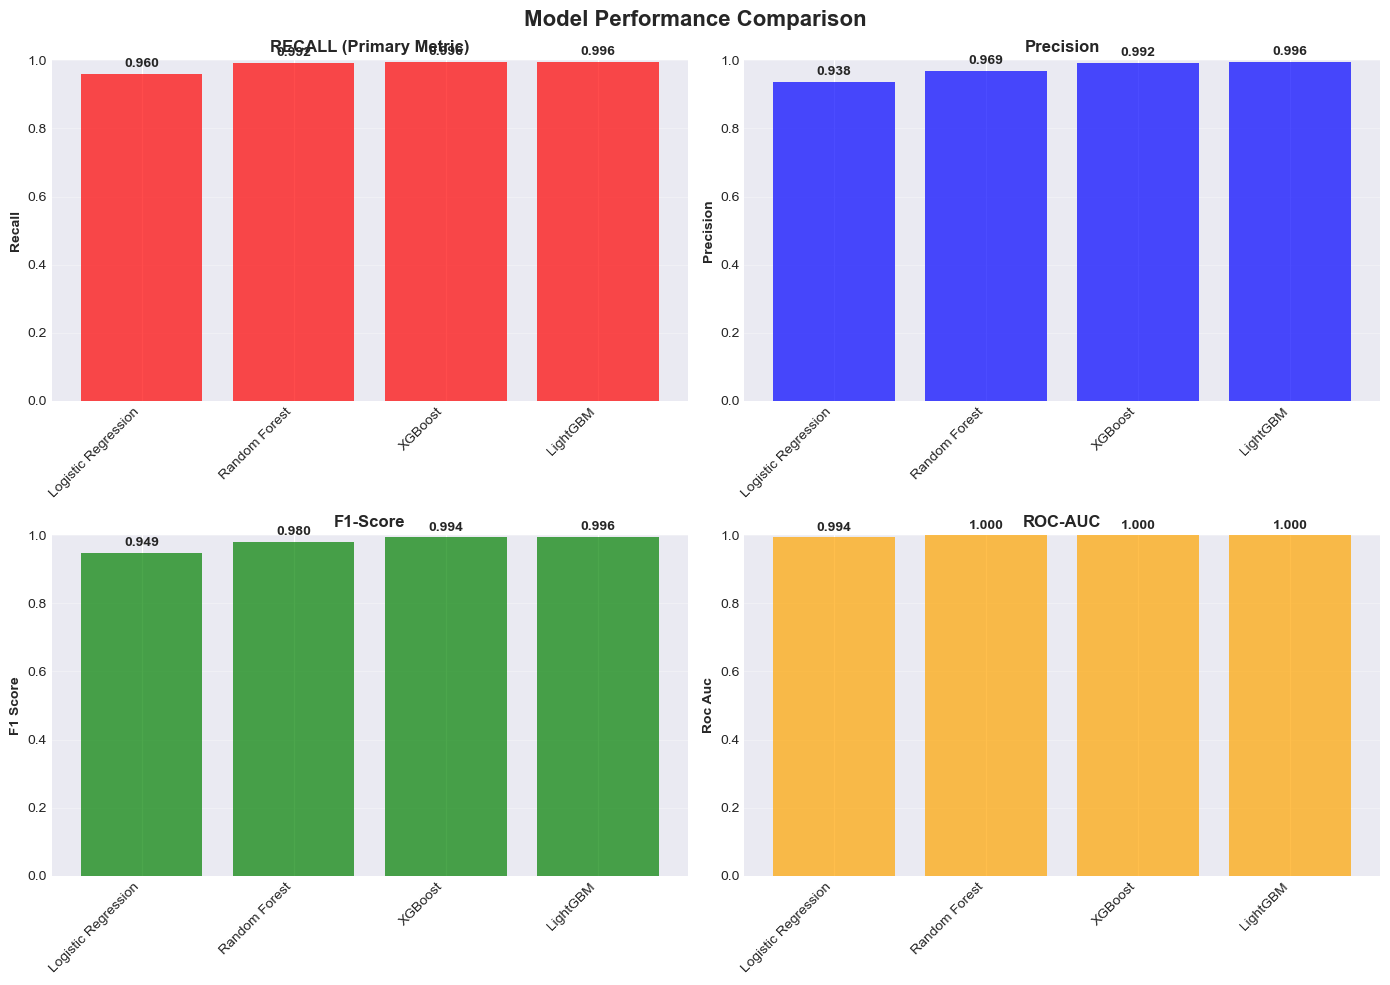

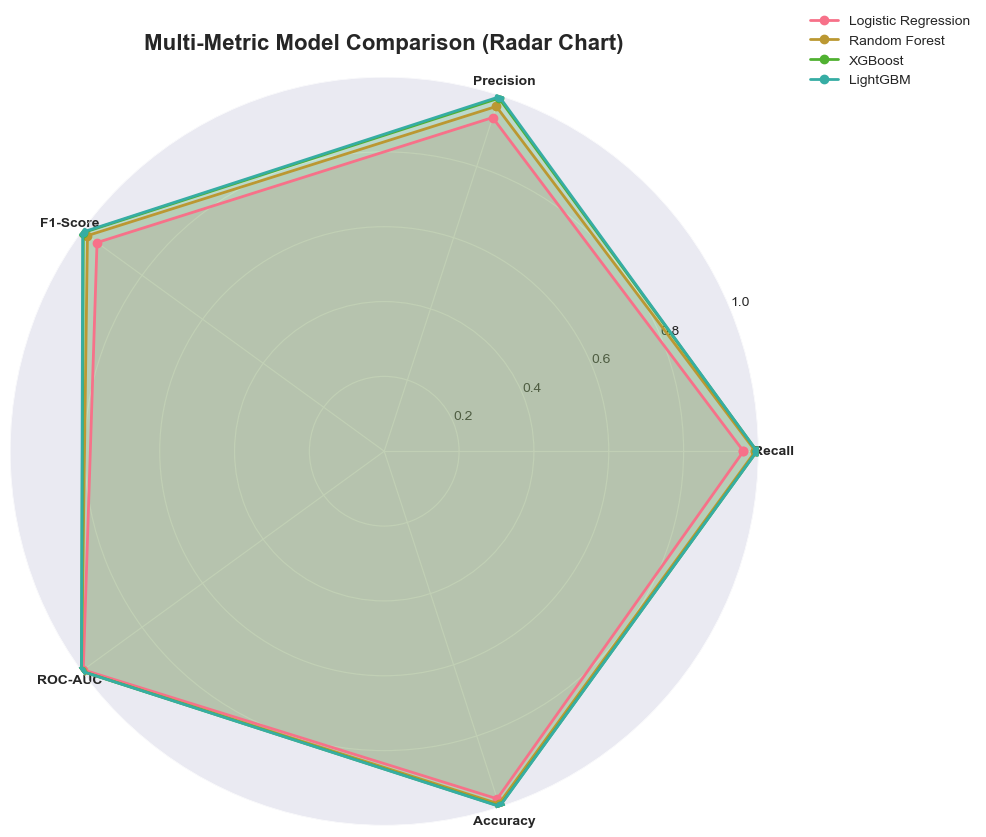

In [47]:
# Bar chart comparing key metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['recall', 'precision', 'f1_score', 'roc_auc']
titles = ['RECALL (Primary Metric)', 'Precision', 'F1-Score', 'ROC-AUC']
colors = ['red', 'blue', 'green', 'orange']

for idx, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
    ax = axes[idx // 2, idx % 2]
    ax.bar(comparison_df['model_name'], comparison_df[metric], color=color, alpha=0.7)
    ax.set_ylabel(metric.replace('_', ' ').title(), fontweight='bold')
    ax.set_title(title, fontweight='bold')
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(comparison_df[metric]):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Radar chart comparing all metrics
import math

categories = ['Recall', 'Precision', 'F1-Score', 'ROC-AUC', 'Accuracy']
num_vars = len(categories)
angles = [n / float(num_vars) * 2 * math.pi for n in range(num_vars)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

for idx, row in comparison_df.iterrows():
    values = [
        row['recall'], 
        row['precision'], 
        row['f1_score'], 
        row['roc_auc'], 
        row['accuracy']
    ]
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=row['model_name'])
    ax.fill(angles, values, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontweight='bold')
ax.set_ylim(0, 1)
ax.set_title('Multi-Metric Model Comparison (Radar Chart)', 
             size=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.show()

## 14. Save All Models and Results

In [50]:
print("\n💾 SAVING ALL MODELS AND RESULTS\n")
print("="*70)

# Save scaler
joblib.dump(scaler, 'scaler_robust.pkl')
print("✓ Saved: scaler_robust.pkl")

# Save feature names
feature_names_df = pd.DataFrame({'feature_name': X_train.columns})
feature_names_df.to_csv('model_feature_names.csv', index=False)
print("✓ Saved: model_feature_names.csv")

# Save detailed results for each model
detailed_results = {
    'comparison_summary': comparison_df,
    'training_samples': len(X_train_balanced),
    'test_samples': len(X_test),
    'n_features': len(X_train.columns),
    'class_balance_after_smote': y_train_balanced.value_counts().to_dict(),
    'best_model': best_model_name,
    'best_recall': best_recall,
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

import json
with open('training_summary.json', 'w') as f:
    json.dump(detailed_results, f, indent=4, default=str)
print("✓ Saved: training_summary.json")

print("\n" + "="*70)
print("✅ ALL MODELS TRAINED AND SAVED SUCCESSFULLY")
print("="*70)

print("\n📁 Generated Files:")
print("  1. model_logistic_regression.pkl")
print("  2. model_random_forest.pkl")
print("  3. model_xgboost.pkl")
print("  4. model_lightgbm.pkl")
print("  5. scaler_robust.pkl")
print("  6. model_comparison_results.csv")
print("  7. model_feature_names.csv")
print("  8. training_summary.json")

print("\n" + "="*70)
print("NEXT STEPS")
print("="*70)
print("1. ✓ Data cleaning & EDA")
print("2. ✓ Feature engineering (90+ features)")
print("3. ✓ Model training (4 models trained)")
print("4. → SHAP interpretability analysis (next notebook)")
print("5. → Winter-specific testing (Objective 5)")
print("="*70)


💾 SAVING ALL MODELS AND RESULTS

✓ Saved: scaler_robust.pkl
✓ Saved: model_feature_names.csv
✓ Saved: training_summary.json

✅ ALL MODELS TRAINED AND SAVED SUCCESSFULLY

📁 Generated Files:
  1. model_logistic_regression.pkl
  2. model_random_forest.pkl
  3. model_xgboost.pkl
  4. model_lightgbm.pkl
  5. scaler_robust.pkl
  6. model_comparison_results.csv
  7. model_feature_names.csv
  8. training_summary.json

NEXT STEPS
1. ✓ Data cleaning & EDA
2. ✓ Feature engineering (90+ features)
3. ✓ Model training (4 models trained)
4. → SHAP interpretability analysis (next notebook)
5. → Winter-specific testing (Objective 5)
